We'll implement LSTM as a single-step model, a multi-step model, and a multioutput model. The single-step model will predict the traffic volume for the next timestep only, the multi-step model will predict the traffic volume for the next 24 hours, and the multi-output model will predict the temperature and traffic volume for the next timestep.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell


In [2]:
url_train = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/train.csv'
train_df = pd.read_csv(url_train, index_col=0)
train_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.760019,0.0,0.758755,0.146447,0.146447
0.738174,0.0,0.560765,0.066987,0.250000
0.698884,0.0,0.463513,0.017037,0.370590
0.668238,0.0,0.370029,0.000000,0.500000
0.643093,0.0,0.325101,0.017037,0.629410


In [3]:
url_val = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/val.csv'
val_df = pd.read_csv(url_val, index_col=0)
val_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.457646,0.01,0.700153,0.370590,0.017037
0.460946,0.20,0.769918,0.250000,0.066987
0.459375,0.05,0.872750,0.146447,0.146447
0.456388,0.20,0.776894,0.066987,0.250000
0.440830,0.05,0.664574,0.017037,0.370590


In [4]:
url_test = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/test.csv'
test_df = pd.read_csv(url_test, index_col=0)
test_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.767405,0.9,0.401563,0.000000,0.500000
0.756876,0.9,0.348821,0.017037,0.629410
0.754833,0.9,0.302637,0.066987,0.750000
0.754833,0.9,0.187108,0.146447,0.853553
0.756247,0.9,0.080926,0.250000,0.933013


In [ ]:
train_df = train_df.reset_index()
val_df   = val_df.reset_index()
test_df  = test_df.reset_index()

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Implementing an LSTM as a single-step model

We'll start by implementing the LSTM architecture as a single-step model. In this case, we'll use 24 hours of data as an input to predict the next timestep. That way, there is a sequence of time that can be processed by the LSTM, allowing us to leverage past information to make a future prediction.

First we need to create a data window to train the model. This will be a wide window, with 24 hours of data as input.



In [9]:
wide_window = DataWindow(input_width=24, 
                         label_width=24, 
                         shift=1,
                         label_columns=['traffic_volume'])

Then we need to define our LSTM model in Keras. We'll set return_sequences to True, as this signals Keras to use past information from the sequence, in the form of the hidden state and cell state, which we covered earlier. Finally, we'll define the output layer, which is simply a Dense layer with one unit because we are forecasting the traffic volume only.

In [10]:
# Set return_sequences to True to make sure that past information is being used by the network.
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

In [11]:
history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0814 - mean_absolute_error: 0.1993 - val_loss: 0.0130 - val_mean_absolute_error: 0.0843
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0102 - mean_absolute_error: 0.0744 - val_loss: 0.0060 - val_mean_absolute_error: 0.0562
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0055 - mean_absolute_error: 0.0543 - val_loss: 0.0044 - val_mean_absolute_error: 0.0483
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0486 - val_loss: 0.0039 - val_mean_absolute_error: 0.0453
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0042 - mean_absolute_error: 0.0464 - val_loss: 0.0037 - val_mean_absolute_error: 0.0435
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0447 - val_loss: 0.0036 - val_mean_absolute_error: 0.0428
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0434 - v

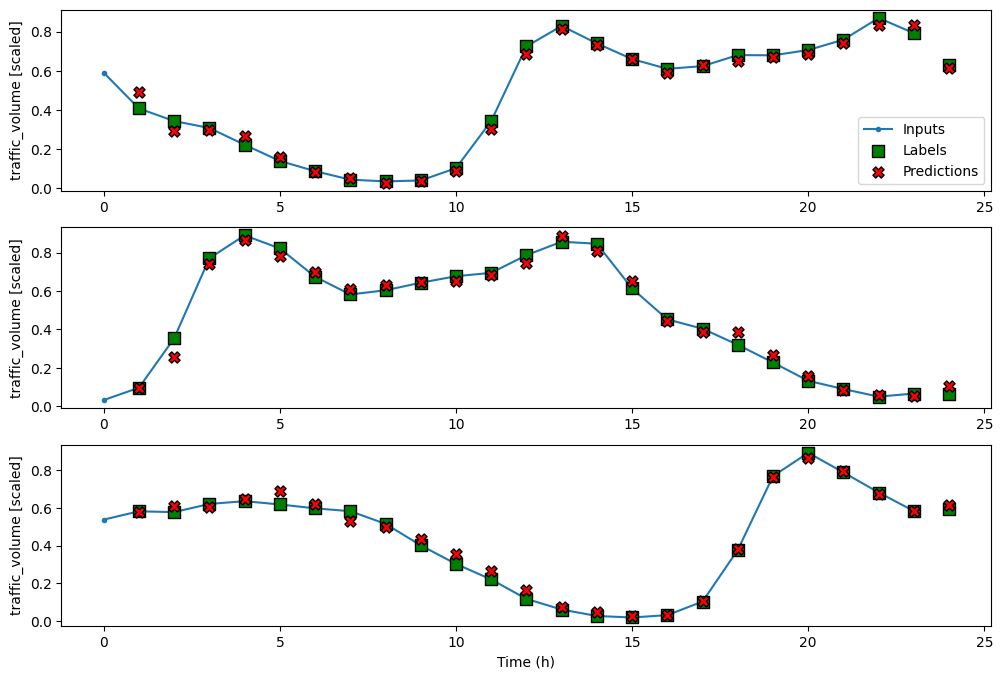

In [12]:
wide_window.plot(lstm_model)

Predicting traffic volume using an LSTM as a single-step model. Many predictions (shown as crosses) overlap the labels (shown as squares), suggesting we have a performant model with accurate predictions.

LSTM is the winning model, since it has the lowest MAE on both the validation and test sets, meaning that it generated the most accurate predictions of all the models.

## Implementing an LSTM as a multi-step model

In this case, we wish to predict traffic volume for next 24 hours, using an input window of 24 hours.

First, we'll define the time window to feed our model. The input_width and label_width are both 24, since we want to input 24 hours of data and evaluate the predictions on 24 hours of data as well. This time the shift is also 24, specifying that the model must output predictions for the next 24 hours in a single shot.

In [13]:
multi_window = DataWindow(input_width=24, 
                          label_width=24, 
                          shift=24,
                          label_columns=['traffic_volume'])

Next, we'll define our model in Keras.

In [14]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [15]:
history = compile_and_fit(ms_lstm_model, multi_window)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0932 - mean_absolute_error: 0.2314 - val_loss: 0.0216 - val_mean_absolute_error: 0.1043
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0178 - mean_absolute_error: 0.0935 - val_loss: 0.0177 - val_mean_absolute_error: 0.0901
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0153 - mean_absolute_error: 0.0838 - val_loss: 0.0166 - val_mean_absolute_error: 0.0855
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0144 - mean_absolute_error: 0.0802 - val_loss: 0.0160 - val_mean_absolute_error: 0.0836
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0139 - mean_absolute_error: 0.0782 - val_loss: 0.0156 - val_mean_absolute_error: 0.0814
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0135 - mean_absolute_error: 0.0768 - val_loss: 0.0151 - val_mean_absolute_error: 0.0800
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0133 - mean_absolute_error: 0.0763 - 

In [16]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - mean_absolute_error: 0.0696


We can visualize the predictions of the model using the plot method

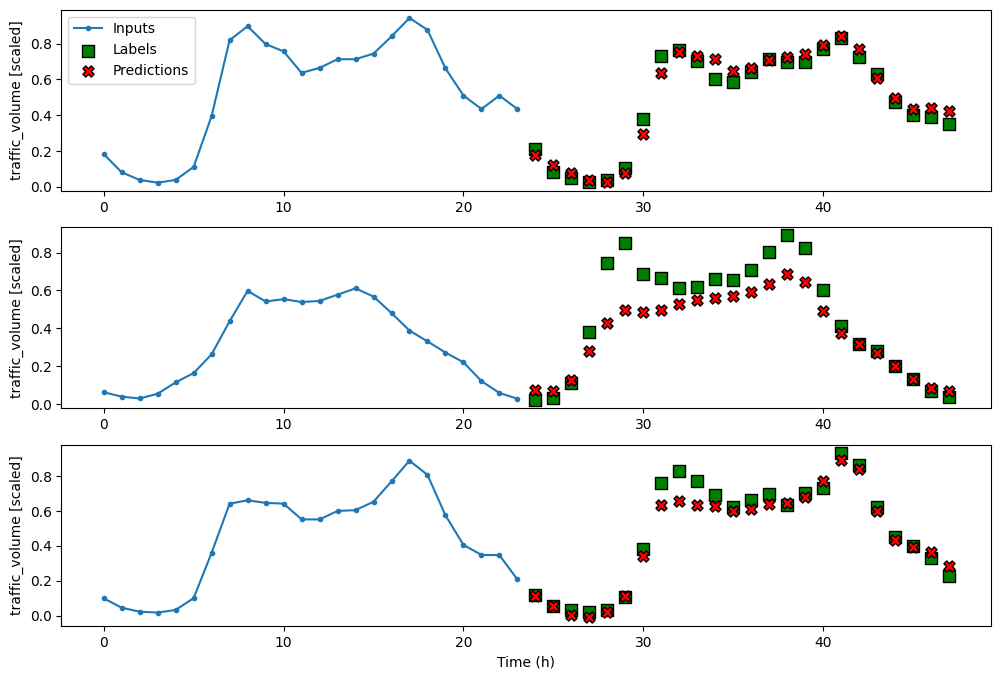

In [17]:
multi_window.plot(ms_lstm_model)

Predicting the traffic volume over the next 24 hours using a multi-step LSTM model. We can see some discrepancies between the predictions and the labels. Of course, this visual inspection is not enough to assess the performance of the model.

## Implementing an LSTM as a multi-output model

Finally, we'll implement an LSTM as a multi-output model. Again, we'll use 24 hours of input data, so that the network can process a sequence of data points and use past information to produce forecasts. The predictions will be for both the traffic volume and temperature at the next timestep.

In this situation, the data window consists of an input of 24 timesteps and 24 timesteps of labels. The shift is 1, as we want to produce forecasts for the next timestep only. Thus, our model will be creating rolling forecasts to generate predictions one timestep at a time, over 24 timesteps. We’ll specify temp and traffic_volume as our target columns.

In [18]:
mo_wide_window = DataWindow(input_width=24, 
                            label_width=24, 
                            shift=1,
                            label_columns=['temp','traffic_volume'])


In [19]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2) # We have two units because we have two targets: the temperature and the traffic volume.
])

Then we'll train the model and store its performance metrics for comparison.

In [20]:
history = compile_and_fit(mo_lstm_model, mo_wide_window)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0485 - mean_absolute_error: 0.1506 - val_loss: 0.0098 - val_mean_absolute_error: 0.0642
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0074 - mean_absolute_error: 0.0559 - val_loss: 0.0042 - val_mean_absolute_error: 0.0414
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0402 - val_loss: 0.0029 - val_mean_absolute_error: 0.0345
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0347 - val_loss: 0.0024 - val_mean_absolute_error: 0.0319
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0322 - val_loss: 0.0021 - val_mean_absolute_error: 0.0293
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0302 - val_loss: 0.0019 - val_mean_absolute_error: 0.0282
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0023 - mean_absolute_error: 0.0288 - 

In [21]:
mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test,verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0208


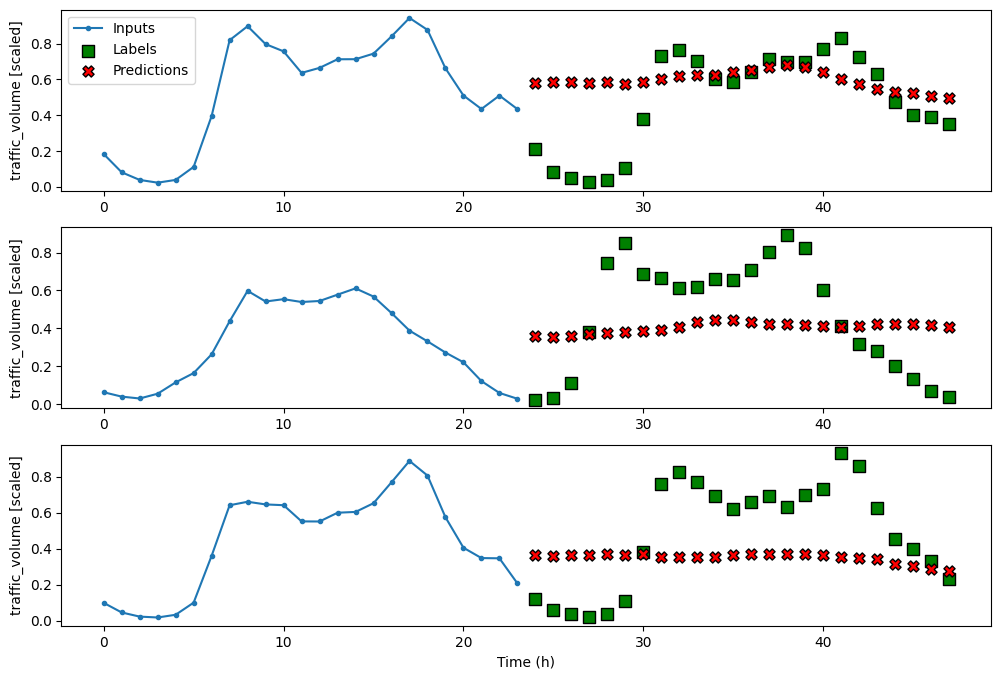

In [22]:
multi_window.plot(mo_lstm_model)